In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

In [2]:
listing = pd.read_csv('data/prepped/lis_out.csv')

In [3]:
listing.head()

,id,name,summary,space,description,neighborhood_overview,notes,transit,host_about,host_listings_count,...,weekly_price_float,monthly_price_float,host_is_super_host,host_response_rate_float,review_true_score,cancel_policy_code,property_code,neighbourhood_code,room_code,zipcode_code
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0000,0,0,0,0,0
1,5956968.0,6.0,44.0,83.0,189.0,22.0,14.0,19.0,40.0,1.0,...,800.0,3476.00,0.0,0.0,2.3275,2,10,13,2,15
2,1909058.0,6.0,39.0,175.0,172.0,15.0,15.0,90.0,42.0,1.0,...,575.0,2498.38,1.0,1.0,2.4354,1,10,13,2,15
3,4948745.0,6.0,32.0,23.0,167.0,81.0,0.0,42.0,44.0,1.0,...,500.0,1700.00,0.0,0.0,1.1834,2,1,13,2,9
4,4454295.0,5.0,37.0,29.0,110.0,16.0,0.0,7.0,45.0,1.0,...,800.0,2000.00,0.0,1.0,0.9506,2,10,13,1,15


In [4]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [5]:
listing.corr().price_float.sort_values()

longitude                        -0.678055
number_of_reviews                 0.178263
host_is_super_host                0.186259
notes                             0.199600
reviews_per_month                 0.213616
review_true_score                 0.214950
transit                           0.231930
calculated_host_listings_count    0.247494
host_about                        0.255858
ep                                0.277775
room_code                         0.278710
host_listings_count               0.281353
host_total_listings_count         0.281353
property_code                     0.286034
neighborhood_overview             0.290341
zipcode_code                      0.362277
maximum_nights                    0.366256
minimum_nights                    0.369200
id                                0.400913
neighbourhood_code                0.409354
sd                                0.415777
space                             0.426187
host_response_rate_float          0.468423
summary    

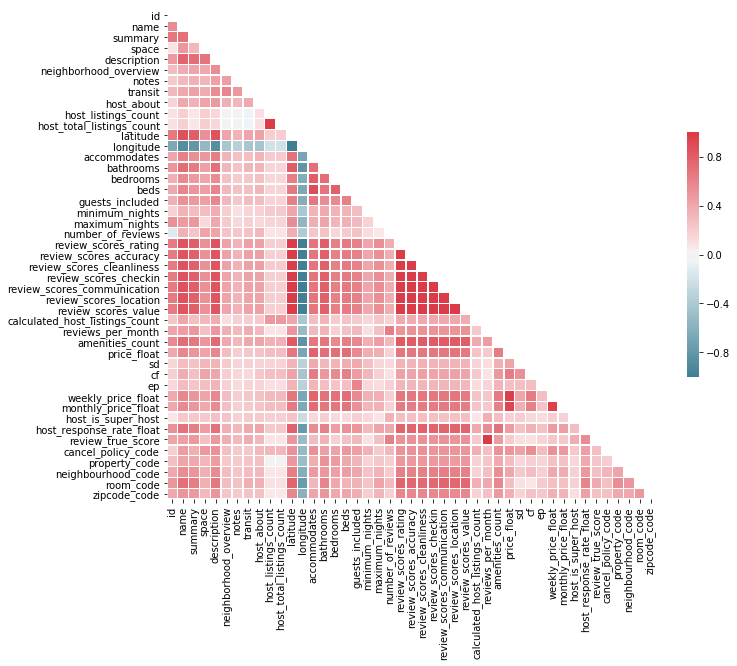

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

mask = np.zeros_like(listing.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(listing.corr(), mask=mask, cmap=cmap, vmax=1.0, center=0, square=True, linewidths=.5, cbar_kws={"shrink":.5})

plt.show()

In [7]:
result = listing.drop(['id',
                       'weekly_price_float',
                       'monthly_price_float'], axis=1)

In [ ]:
mod = forward_selected(result, 'price_float')

In [38]:
train_features, test_features, train_outcome, test_outcome = train_test_split(
    result.drop('price_float', axis=1),
    result.price_float,
    test_size=0.30,
    random_state=15
)

In [39]:
from sklearn.svm import SVR

estimator = SVR(kernel='linear')
selector = RFE(estimator, 5, step=1)

In [ ]:
mod.summary()

In [ ]:
selector = selector.fit(train_features, train_outcome)

In [ ]:
selector.score(test_features, test_outcome)

In [ ]:
plt.scatter(test_outcome, selector.predict(test_features))

In [ ]:
from sklearn.neighbors import KNeighborsRegressor    # KNN regressor
from sklearn.preprocessing import MinMaxScaler      # scaling data
from sklearn.pipeline import make_pipeline 

#Regression Model
knn_reg = KNeighbors Regressor()

# Define a pipeline that uses your scaler and classifier
pipe_knn = make_pipeline(knn_reg)

# Define a grid to search through
param_grid_knn = {'kneighborsregressor__n_neighbors':range(1, 20), 
                  'kneighborsregressor__weights':["uniform", "distance"],
                  'kneighborsregressor__algorithm':['auto', 'ball_tree', 'kd_tree']}

# Perform a  grid search of your pipeline
grid_knn = GridSearchCV(pipe_knn, param_grid_knn, scoring="neg_mean_absolute_error")

In [ ]:
grid_knn.fit(train_features, train_outcome)

In [ ]:
grid_knn.score(test_features, test_outcome)

In [ ]:
grid_knn.best_params_

In [ ]:
plt.scatter(test_outcome, grid_knn.predict(test_features))

In [ ]:
sns.boxplot(x=result_NAN.total_bookings)

In [ ]:
sns.boxplot(x=result_NAN.price_int)

In [ ]:
from scipy import stats

new_result = result_NAN.drop(['latitude', 'longitude'], axis=1)

z = np.abs(stats.zscore(new_result))

result_out = new_result[(z < 3).all(axis=1)]

result_out = result_out.dropna()

result_out

In [ ]:
#result_out[result_out.isnull().any(axis=1)]

In [ ]:
#mod2 = forward_selected(result_out, 'total_bookings')

In [ ]:
#mod2.summary()

In [ ]:
result_out.corr().total_bookings